In [4]:
import os
import sys
sys.path.append(os.path.join("../"))

from rdkit import Chem
from rdkit.Chem import Descriptors
from utils.lipinski_utils import compute_lipinski, compute_logp, compute_qed
from utils.filter import apply_filters
import pandas as pd
from rdkit.Chem import RDConfig
sys.path.append(os.path.join(RDConfig.RDContribDir, "SA_Score"))
import sascorer
from utils.data import compund_to_csv
from datetime import datetime
from os import listdir
from os.path import isfile, join
import numpy as np

In [25]:
folder_path = "../experiment_results/compound_samples"
file_name_soft = "compound_stats-noisy-lstm-v3-insilico_KRAS-bYVMLCZCbj-02Feb2023T1815-100000.csv"
file_name_hard = "compound_stats-noisy-lstm-v3-insilico_KRAS-BJMOEEqbms-02Feb2023T1718-100000.csv"
data_set_initial = "/Users/mohamad/workspace/repos/insilico-drug-discovery/data/KRAS_G12D/KRAS_G12D_inhibitors_update2023.csv"


In [15]:
compund_genereted_files ="../experiment_results/samples/samples/"
files = [f for f in listdir(compund_genereted_files) if isfile(join(compund_genereted_files, f))] 

In [ ]:
all_data = pd.read_csv(f"{compund_genereted_files}{files[0]}",index_col = [0])
for file in files[1::]:
    all_data = all_data.append(pd.read_csv(f"{compund_genereted_files}{file}",index_col = [0]), ignore_index = True)

In [41]:
all_data.to_csv("merged_samples.csv")

In [57]:
all_data.count()

smiles     2309287
logP       2309287
SAscore    2309287
QED        2309287
dtype: int64

In [45]:
new_samples= all_data.drop_duplicates().reset_index()

In [49]:
filtered = new_samples.query("SAscore<=4.5 and QED>=0.3").reset_index()

In [53]:
filtered.to_csv("filtered_samples.csv")

In [55]:
new_samples.count()

index      1871496
smiles     1871496
logP       1871496
SAscore    1871496
QED        1871496
dtype: int64

# analyze

In [27]:
data_qcbm= "filtered_samples.csv"

In [28]:
df_data_new_qcbm = pd.read_csv(data_qcbm,index_col = [0])
df_data_set = pd.read_csv(data_set_initial,index_col = [0])

In [29]:
df_data_set.count()

id              696
smiles          696
kras_spr        272
perk_ic50       679
binding_ic50    471
selfies         696
dtype: int64

In [30]:
df_data_new_qcbm.count()

level_0    1794697
index      1794697
smiles     1794697
logP       1794697
SAscore    1794697
QED        1794697
dtype: int64

In [10]:
# QCBM
file_name_qcbm_soft = "compound_stats-noisy-lstm-v3-insilico_KRAS-goHJdxqAdJ-08Feb2023T1522-100000-soft-models.priors.qcbm.QCBMSamplingFunction_v3.csv"
file_name_qcbm_hard = "compound_stats-noisy-lstm-v3-insilico_KRAS-laJSIjuGWP-08Feb2023T1522-100000-hard-models.priors.qcbm.QCBMSamplingFunction_v3.csv"
# RBM
file_name_rbm_soft = "compound_stats-noisy-lstm-v3-insilico_KRAS-EWYYPcGmqV-08Feb2023T1551-100000-soft-RBM(model_state=train).csv"
file_name_rbm_hard = "compound_stats-noisy-lstm-v3-insilico_KRAS-teaNNjCDGd-08Feb2023T1551-100000-hard-RBM(model_state=train).csv"
# Random
file_name_random_soft = "compound_stats-noisy-lstm-v3-insilico_KRAS-JlgZNcRpYn-08Feb2023T1549-100000-soft-RandomChoiceSampler(model_state=train,sampler_dimension=10,choices=tensor([0., 1.], dtype=torch.float64),choice_weights=tensor([0.5000, 0.5000])).csv"
file_name_random_hard = "compound_stats-noisy-lstm-v3-insilico_KRAS-zDvdxvOgmW-08Feb2023T1549-100000-hard-RandomChoiceSampler(model_state=train,sampler_dimension=10,choices=tensor([0., 1.], dtype=torch.float64),choice_weights=tensor([0.5000, 0.5000])).csv"
file_names = { "qcbm_soft" : file_name_qcbm_soft, "qcbm_hard" :file_name_qcbm_hard, "rbm_soft" :file_name_rbm_soft, "rbm_hard" : file_name_rbm_hard,  "random_soft" :file_name_random_soft,"random_hard" :file_name_random_hard}
len(file_names)

6

In [11]:
df={}
for kk,ff in file_names.items():
    df[kk] = pd.read_csv(f"{folder_path}/{ff}",index_col = [0])
    df[kk]['filter'] = df[kk]['smiles'].apply(lambda x:apply_filters(x) )
# df_qcbm_hard = pd.read_csv(f"{folder_path}/{file_name_hard}",index_col = [0])


[11:21:17] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[11:24:44] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.


In [12]:
new_df = {}
for prior_name in ["qcbm","rbm","random"]:
    new_df[prior_name] = df[f"{prior_name}_hard"].query("SAscore<=4.5 and QED>=0.3 and filter == True").reset_index().copy()

In [13]:
new_soft_df = {}
for prior_name in ["qcbm","rbm","random"]:
    new_soft_df[prior_name] = df[f"{prior_name}_soft"].query("SAscore<=4.5 and QED>=0.3 and filter == True").reset_index().copy()

In [32]:
print("Train with hard filter")
print(f"QCBM: Total # comounds:{new_df['qcbm']['QED'].count()}, QCBM mean QED {new_df['qcbm']['QED'].mean()}, QCBM max QED {new_df['qcbm']['QED'].max()}\
, QCBM mean SA {new_df['qcbm']['SAscore'].mean()}, QCBM min SA {new_df['qcbm']['SAscore'].min()}\n")
print(f"RBM: Total # comounds:{new_df['rbm']['QED'].count()}, RBM mean QED {new_df['rbm']['QED'].mean()}, RBM max QED {new_df['rbm']['QED'].max()}\
, RBM mean SA {new_df['rbm']['SAscore'].mean()}, RBM min SA {new_df['rbm']['SAscore'].min()}\n")
print(f"Random: Total # comounds:{new_df['random']['QED'].count()}, Random mean QED {new_df['random']['QED'].mean()}, Random max QED {new_df['random']['QED'].max()}\
, Random mean SA {new_df['random']['SAscore'].mean()}, Random min SA {new_df['random']['SAscore'].min()}\n")
      
print(f"QGenerator 1M: Total # comounds:{df_data_new_qcbm['QED'].count()}, QGenerator mean QED {df_data_new_qcbm['QED'].mean()}, QGenerator max QED {df_data_new_qcbm['QED'].max()}\
, QGenerator mean SA {df_data_new_qcbm['SAscore'].mean()}, QGenerator min SA {df_data_new_qcbm['SAscore'].min()}")


Train with hard filter
QCBM: Total # comounds:1761, QCBM mean QED 0.5907652063629903, QCBM max QED 0.9238871869607436, QCBM mean SA 3.9242517291031187, QCBM min SA 2.522003573220788

RBM: Total # comounds:1367, RBM mean QED 0.549640331809294, RBM max QED 0.9308689174579262, RBM mean SA 3.955700319726934, RBM min SA 2.522003573220788

Random: Total # comounds:1393, Random mean QED 0.5624820119096605, Random max QED 0.922039720144939, Random mean SA 3.97289705915454, Random min SA 2.567726236176643

QGenerator 1M: Total # comounds:1794697, QGenerator mean QED 0.6308684001979616, QGenerator max QED 0.9480683421859714, QGenerator mean SA 3.6676197488330273, QGenerator min SA 1.7732048079388676


In [9]:
print("Train with soft filter")
print(f"QCBM: Total # comounds:{new_soft_df['qcbm']['QED'].count()}, QCBM mean QED {new_soft_df['qcbm']['QED'].mean()}, QCBM max QED {new_soft_df['qcbm']['QED'].max()}\
, QCBM mean SA {new_soft_df['qcbm']['SAscore'].mean()}, QCBM min SA {new_soft_df['qcbm']['SAscore'].min()}")
print(f"RBM: Total # comounds:{new_soft_df['rbm']['QED'].count()}, RBM mean QED {new_soft_df['rbm']['QED'].mean()}, RBM max QED {new_soft_df['rbm']['QED'].max()}\
, RBM mean SA {new_soft_df['rbm']['SAscore'].mean()}, RBM min SA {new_soft_df['rbm']['SAscore'].min()}")
print(f"Random: Total # comounds:{new_soft_df['random']['QED'].count()} , Random mean QED {new_soft_df['random']['QED'].mean()}, Random max QED {new_soft_df['random']['QED'].max()}\
, Random mean SA {new_soft_df['random']['SAscore'].mean()}, Random min SA {new_soft_df['random']['SAscore'].min()}")


Train with soft filter
QCBM: Total # comounds:1853, QCBM mean QED 0.5878963704602557, QCBM max QED 0.9362131438423884, QCBM mean SA 3.9207143632291506, QCBM min SA 2.383236332982777
RBM: Total # comounds:1105, RBM mean QED 0.573255319060827, RBM max QED 0.9345031329681336, RBM mean SA 3.9271714295352824, RBM min SA 2.4419589578361727
Random: Total # comounds:1038 , Random mean QED 0.5682922714027547, Random max QED 0.9362131438423884, Random mean SA 3.983494241927848, Random min SA 2.567726236176643


In [33]:
folder_path_figures = "../experiment_results/figures/"

In [34]:
def comp_sascore(x):
    return sascorer.calculateScore(Chem.MolFromSmiles(x))

In [12]:
compute_qed("CN1[C@H](COc2nc3cc(-c4cc(O)cc5ccccc45)ncc3c(N3CC(CC4)NC4C3)n2)CCC1")

0.4294354642456557

In [35]:
df_data_set['SAscore'] = df_data_set['smiles'].apply(lambda x: comp_sascore(x))

In [36]:
df_data_set['QED'] = df_data_set['smiles'].apply(lambda x: compute_qed(x))

In [37]:
f"{folder_path}/{datetime.now().strftime('%d_%m_%Y_%H_%M_%S')}"

'../experiment_results/compound_samples/28_02_2023_12_28_20'

In [38]:
file_output = f"/Users/mohamad/workspace/repos/insilico-drug-discovery/data/KRAS_G12D/KRAS_{datetime.now().strftime('%d_%m_%Y_%H_%M_%S')}.csv"

In [39]:
df_data_set["QED"].describe()

count    696.000000
mean       0.394279
std        0.125001
min        0.118829
25%        0.314584
50%        0.374915
75%        0.470598
max        0.908356
Name: QED, dtype: float64

In [40]:
df_data_set["SAscore"].describe()

count    696.000000
mean       5.041759
std        0.564187
min        2.814893
25%        4.787490
50%        5.046479
75%        5.453468
max        6.706430
Name: SAscore, dtype: float64

In [58]:
df_hard_filtered.to_csv(f"{folder_path}/df_hard_filtered_{datetime.now().strftime('%d_%m_%Y_%H_%M_%S')}.csv")

In [59]:
df_soft_filtered.to_csv(f"{folder_path}/df_soft_filtered_{datetime.now().strftime('%d_%m_%Y_%H_%M_%S')}.csv")

In [41]:
df_data_set['QED'].mean()

0.3942788521546022

In [47]:
new_qcbm = df_data_new_qcbm.query("SAscore<=4.5 and QED>=0.3")


In [51]:
new_qcbm['QED'].mean()

0.6308684001979616

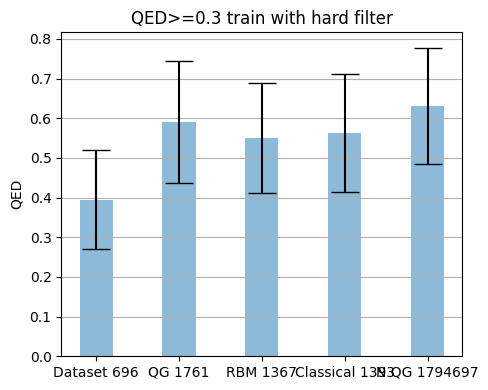

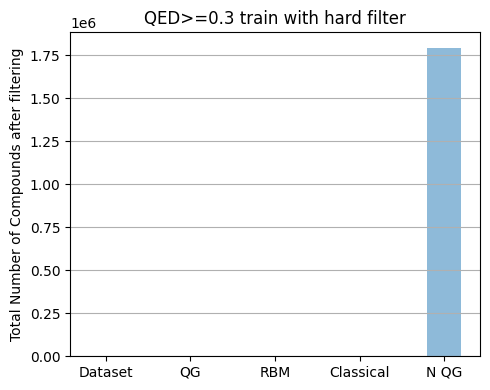

In [52]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
df = new_df.copy()

dataset_qed = np.asarray(df_data_set['QED'].mean())
dataset_qed_std = np.std(df_data_set['QED'])
n_dataset = df_data_set['SAscore'].count()

qcbm_qed = np.asarray(df['qcbm']['QED'].mean())
qcbm_qed_std = np.std(df['qcbm']['QED'])
n_qcbm = df['qcbm']['SAscore'].count()

rbm_qed = np.asarray(df['rbm']['QED'].mean())
rbm_qed_std = np.std(df['rbm']['QED'])
n_rbm = df['rbm']['SAscore'].count()



random_qed = np.asarray(df['random']['QED'].mean())
random_qed_std = np.std(df['random']['QED'])
n_random = df['random']['SAscore'].count()

qcbm_new_qed = np.asarray(new_qcbm['QED'].mean())
qcbm_new_qed_std = np.std(new_qcbm['QED'])
n_qcbm_new = new_qcbm['SAscore'].count()


materials = [f'Dataset {n_dataset}',f'QG {n_qcbm}',f'RBM {n_rbm}',f'Classical {n_random}',f'N QG {n_qcbm_new}']
x_pos = np.arange(len(materials))

y_pos = [dataset_qed,qcbm_qed,rbm_qed,random_qed,qcbm_new_qed]
yrr_pos = [dataset_qed_std,qcbm_qed_std,rbm_qed_std,random_qed_std,qcbm_new_qed_std]





fig, ax = plt.subplots(figsize=(5,4))
ax.bar(x_pos, y_pos, yerr=yrr_pos,width=0.4, align='center', alpha=0.5, ecolor='black', capsize=10)
# ax.set_ylabel('QED ($\degree C^{-1}$)')
ax.set_ylabel('QED')
ax.set_xticks(x_pos)
ax.set_xticklabels(materials)
ax.set_title('')
ax.yaxis.grid(True)
ax.set_title('QED>=0.3 train with hard filter')
# Save the figure and show
plt.tight_layout()
plt.savefig('QED_hard_bar_plot_with_error_bars.png')
plt.show()


y_count = [n_dataset,n_qcbm,n_rbm,n_random,n_qcbm_new]
materials = [f'Dataset',f'QG',f'RBM',f'Classical',f'N QG']

fig, ax = plt.subplots(figsize=(5,4))
ax.bar(x_pos, y_count, align='center',width=0.4, alpha=0.5, ecolor='black', capsize=10)
# ax.set_ylabel('QED ($\degree C^{-1}$)')
ax.set_ylabel('Total Number of Compounds after filtering')
ax.set_xticks(x_pos)
ax.set_xticklabels(materials)
ax.set_title('')
ax.yaxis.grid(True)
ax.set_title('QED>=0.3 train with hard filter')
# Save the figure and show
plt.tight_layout()
plt.savefig('QED_n_hard_bar_plot_with_error_bars.png')
plt.show()


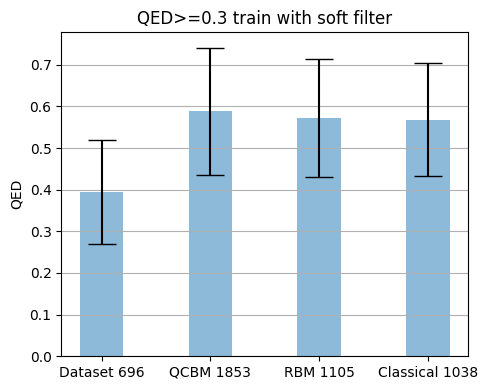

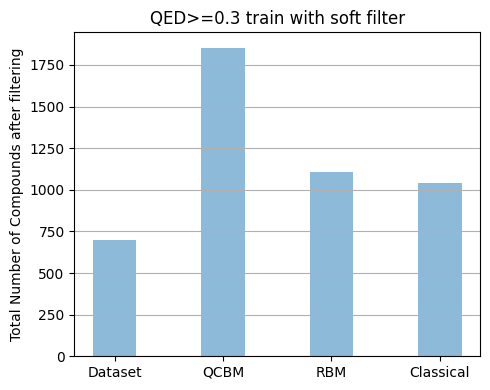

In [81]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
df = new_soft_df.copy()

dataset_qed = np.asarray(df_data_set['QED'].mean())
dataset_qed_std = np.std(df_data_set['QED'])
n_dataset = df_data_set['SAscore'].count()

qcbm_qed = np.asarray(df['qcbm']['QED'].mean())
qcbm_qed_std = np.std(df['qcbm']['QED'])
n_qcbm = df['qcbm']['SAscore'].count()

rbm_qed = np.asarray(df['rbm']['QED'].mean())
rbm_qed_std = np.std(df['rbm']['QED'])
n_rbm = df['rbm']['SAscore'].count()



random_qed = np.asarray(df['random']['QED'].mean())
random_qed_std = np.std(df['random']['QED'])
n_random = df['random']['SAscore'].count()

materials = [f'Dataset {n_dataset}',f'QCBM {n_qcbm}',f'RBM {n_rbm}',f'Classical {n_random}']
x_pos = np.arange(len(materials))

y_pos = [dataset_qed,qcbm_qed,rbm_qed,random_qed]
yrr_pos = [dataset_qed_std,qcbm_qed_std,rbm_qed_std,random_qed_std]





fig, ax = plt.subplots(figsize=(5,4))
ax.bar(x_pos, y_pos, yerr=yrr_pos, align='center',width=0.4, alpha=0.5, ecolor='black', capsize=10)
# ax.set_ylabel('QED ($\degree C^{-1}$)')
ax.set_ylabel('QED')
ax.set_xticks(x_pos)
ax.set_xticklabels(materials)
ax.set_title('')
ax.yaxis.grid(True)
ax.set_title('QED>=0.3 train with soft filter')
# Save the figure and show
plt.tight_layout()
plt.savefig('QED_soft_bar_plot_with_error_bars.png')
plt.show()



y_count = [n_dataset,n_qcbm,n_rbm,n_random]
materials = [f'Dataset',f'QCBM',f'RBM',f'Classical']


fig, ax = plt.subplots(figsize=(5,4))
ax.bar(x_pos, y_count, align='center',width=0.4, alpha=0.5, ecolor='black', capsize=10)
# ax.set_ylabel('QED ($\degree C^{-1}$)')
ax.set_ylabel('Total Number of Compounds after filtering')
ax.set_xticks(x_pos)
ax.set_xticklabels(materials)
ax.set_title('')
ax.yaxis.grid(True)
ax.set_title('QED>=0.3 train with soft filter')
# Save the figure and show
plt.tight_layout()
plt.savefig('QED_n_soft_bar_plot_with_error_bars.png')
plt.show()



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


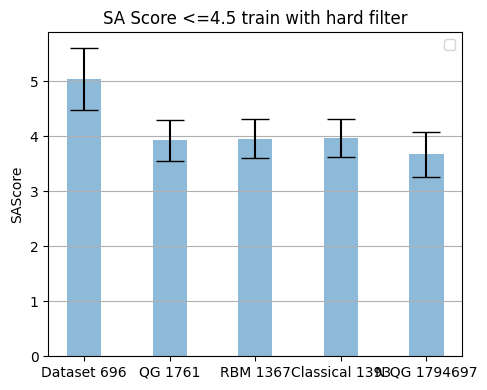

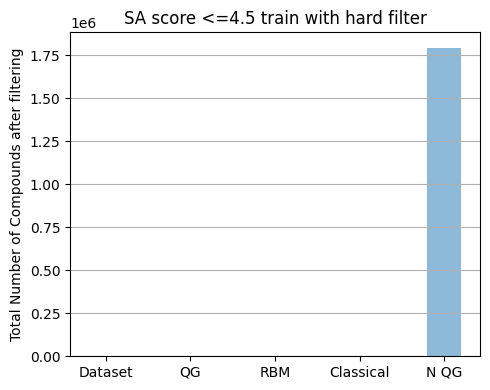

In [60]:
df = new_df.copy()
dataset_sascore = np.asarray(df_data_set['SAscore'].mean())
dataset_sascore_std = np.std(df_data_set['SAscore'])
n_dataset = df_data_set['SAscore'].count()

qcbm_sascore = np.asarray(df['qcbm']['SAscore'].mean())
qcbm_sascore_std = np.std(df['qcbm']['SAscore'])
n_qcbm = df['qcbm']['SAscore'].count()

rbm_sascore = np.asarray(df['rbm']['SAscore'].mean())
rbm_sascore_std = np.std(df['rbm']['SAscore'])
n_rbm = df['rbm']['SAscore'].count()


random_sascore = np.asarray(df['random']['SAscore'].mean())
random_sascore_std = np.std(df['random']['SAscore'])
n_random = df['random']['SAscore'].count()


qcbm_new_sascore = np.asarray(new_qcbm['SAscore'].mean())
qcbm_new_sascore_std = np.std(new_qcbm['SAscore'])
n_qcbm_new = new_qcbm['SAscore'].count()



y_pos = [dataset_sascore,qcbm_sascore,rbm_sascore,random_sascore,qcbm_new_sascore]
yrr_pos = [dataset_sascore_std,qcbm_sascore_std,rbm_sascore_std,random_sascore_std,qcbm_new_sascore_std]

materials = [f'Dataset {n_dataset}',f'QG {n_qcbm}',f'RBM {n_rbm}',f'Classical {n_random}',f'N QG {n_qcbm_new}']
x_pos = np.arange(len(materials))



fig, ax = plt.subplots(figsize=(5,4))
ax.bar(x_pos, y_pos, yerr=yrr_pos,width=0.4, align='center', alpha=0.5, ecolor='black', capsize=10)
# ax.set_ylabel('QED ($\degree C^{-1}$)')
ax.set_ylabel('SAScore')
ax.set_xticks(x_pos)
ax.set_xticklabels(materials)
ax.set_title('')
ax.yaxis.grid(True)
ax.set_title('SA Score <=4.5 train with hard filter')

# Save the figure and show
plt.tight_layout()
plt.legend()
plt.savefig('SAscore_hard_bar_plot_with_error_bars.png')
plt.show()




y_count = [n_dataset,n_qcbm,n_rbm,n_random,n_qcbm_new]
materials = [f'Dataset',f'QG',f'RBM',f'Classical', f'N QG']
fig, ax = plt.subplots(figsize=(5,4))
ax.bar(x_pos, y_count, align='center',width=0.4, alpha=0.5, ecolor='black', capsize=10)
# ax.set_ylabel('QED ($\degree C^{-1}$)')
ax.set_ylabel('Total Number of Compounds after filtering')
ax.set_xticks(x_pos)
ax.set_xticklabels(materials)
ax.set_title('')
ax.yaxis.grid(True)
ax.set_title('SA score <=4.5 train with hard filter')
# Save the figure and show
plt.tight_layout()
plt.savefig('SAscore_n_hard_bar_plot_with_error_bars.png')
plt.show()

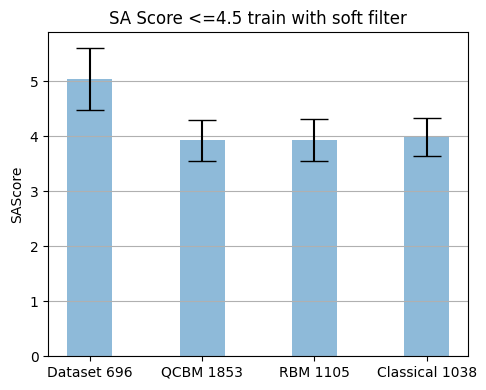

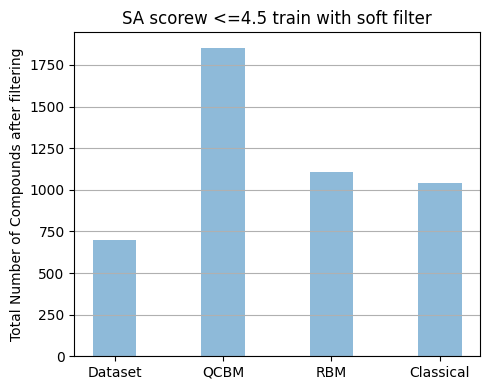

In [79]:
df = new_soft_df.copy()
dataset_sascore = np.asarray(df_data_set['SAscore'].mean())
dataset_sascore_std = np.std(df_data_set['SAscore'])
n_dataset = df_data_set['SAscore'].count()

qcbm_sascore = np.asarray(df['qcbm']['SAscore'].mean())
qcbm_sascore_std = np.std(df['qcbm']['SAscore'])
n_qcbm = df['qcbm']['SAscore'].count()

rbm_sascore = np.asarray(df['rbm']['SAscore'].mean())
rbm_sascore_std = np.std(df['rbm']['SAscore'])
n_rbm = df['rbm']['SAscore'].count()


random_sascore = np.asarray(df['random']['SAscore'].mean())
random_sascore_std = np.std(df['random']['SAscore'])
n_random = df['random']['SAscore'].count()



y_pos = [dataset_sascore,qcbm_sascore,rbm_sascore,random_sascore]
yrr_pos = [dataset_sascore_std,qcbm_sascore_std,rbm_sascore_std,random_sascore_std]

materials = [f'Dataset {n_dataset}',f'QCBM {n_qcbm}',f'RBM {n_rbm}',f'Classical {n_random}']
x_pos = np.arange(len(materials))



fig, ax = plt.subplots(figsize=(5,4))
ax.bar(x_pos, y_pos, yerr=yrr_pos,width=0.4, align='center', alpha=0.5, ecolor='black', capsize=10)
# ax.set_ylabel('QED ($\degree C^{-1}$)')
ax.set_ylabel('SAScore')
ax.set_xticks(x_pos)
ax.set_xticklabels(materials)
ax.set_title('')
ax.yaxis.grid(True)
ax.set_title('SA Score <=4.5 train with soft filter')

# Save the figure and show
plt.tight_layout()
plt.savefig('SAscore_soft_bar_plot_with_error_bars.png')
plt.show()


y_count = [n_dataset,n_qcbm,n_rbm,n_random]
materials = [f'Dataset',f'QCBM',f'RBM',f'Classical']
fig, ax = plt.subplots(figsize=(5,4))
ax.bar(x_pos, y_count, align='center',width=0.4, alpha=0.5, ecolor='black', capsize=10)
# ax.set_ylabel('QED ($\degree C^{-1}$)')
ax.set_ylabel('Total Number of Compounds after filtering')
ax.set_xticks(x_pos)
ax.set_xticklabels(materials)
ax.set_title('')
ax.yaxis.grid(True)
ax.set_title('SA scorew <=4.5 train with soft filter')
# Save the figure and show
plt.tight_layout()
plt.savefig('SAscore_n_soft_bar_plot_with_error_bars.png')
plt.show()


In [17]:
sim_uniq_2023_res_short = pd.read_csv("/Users/mohamad/workspace/repos/insilico-drug-discovery/experiment_results/insilico_chemistry_42/stone_results/sim_uniq_2023_res_short.csv")
uniq_2023_res_short = pd.read_csv("/Users/mohamad/workspace/repos/insilico-drug-discovery/experiment_results/insilico_chemistry_42/stone_results/uniq_2023_res_short.csv")

In [18]:
sim_uniq_2023_res_short[sim_uniq_2023_res_short['Filters Passed']==True]

,initial_smile,SA,ReRSA,Flexibility,MCE-18,SLogP,TopoPSA,Rotatable Bonds Count,Not Passed Modules,Filters Passed,Reward,Novelty
53,CC1=C(COCC2CCCN2C)CN(c2c(C)ccc3[nH]ncc23)CC1,4.755024,5.233778,2.240200,71.909088,3.303971,45.590000,5.0,NaN,True,0.147120,0.311470
280,CC(C)c1ccccc1-c1ncc2cnc(OCC34CCCN3CC(F)C4)nc2c1F,4.944612,5.804892,1.003970,95.199997,4.677753,52.340000,5.0,NaN,True,0.119709,0.333333
318,Cc1cccc2cncc(N3CCc4c(nc(OCC5CCCN5)nc4NCC4CCN4)...,4.538836,6.004021,1.393230,101.871796,2.992786,91.809998,7.0,NaN,True,0.119259,0.372066
495,CCC1CCN(c2nc(OCC3CCCN3C)nc3c2CCN(c2cncc4c(F)cc...,4.625361,4.472373,0.936728,108.860466,4.213281,58.820000,6.0,NaN,True,0.128152,0.340938
580,Cc1ccc2[nH]ncc2c1N1CCc2c(nc(OCC3CCCCO3)n2C)C1,3.599435,2.912827,0.754989,87.500000,3.115420,68.199997,4.0,NaN,True,0.090710,0.311153
...,...,...,...,...,...,...,...,...,...,...,...,...
957577,CN1CCCC1COc1nc2c(c(N3CCNC4(CC4)C3)n1)CCN(c1c(O...,5.123268,4.342159,0.719634,148.800003,2.117762,78.190002,5.0,NaN,True,0.114930,0.308522
957657,CC1=CCN(c2nc(OCC34CCCN3CCC4)nc3c(F)c(-c4ccccc4...,4.203116,5.434290,0.766967,80.410255,4.472389,75.809998,5.0,NaN,True,0.137154,0.336008
957835,CCC1CN(c2nc(OCC34CCCN3CCC4)nc3cc(-c4cnccc4C(C)...,4.524573,5.394993,1.092360,111.304344,4.183565,80.500000,7.0,NaN,True,0.152709,0.314344
957887,CC1c2nc(OCC3CCCCN3)[nH]c2CCN1c1ccccc1,4.497066,5.792810,0.758277,67.482758,3.241675,57.759998,4.0,NaN,True,0.108633,0.275793


In [30]:
smi = sim_uniq_2023_res_short[sim_uniq_2023_res_short['Filters Passed']==True].sort_values(by='SA',ascending=True)
smi.to_csv('sim_uniq_2023_res_short_sascore.csv',index=False)

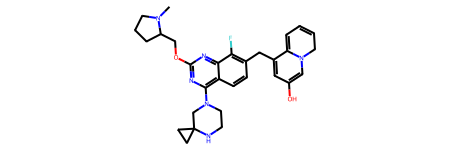

In [29]:
Chem.MolFromSmiles(smi['initial_smile'][735149])

In [31]:
smi2 = uniq_2023_res_short[uniq_2023_res_short['Filters Passed']==True].sort_values(by='SA',ascending=True)
smi2.to_csv('uniq_2023_res_short_sascore.csv',index=False)

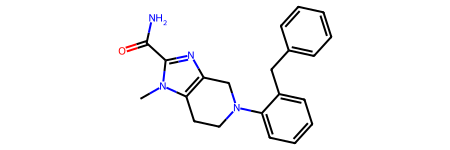

In [22]:
Chem.MolFromSmiles('Cn1c(C(N)=O)nc2c1CCN(c1ccccc1Cc1ccccc1)C2')

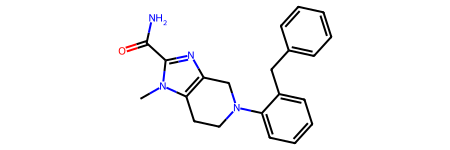

In [23]:
Chem.MolFromSmiles('Cn1c(C(N)=O)nc2c1CCN(c1ccccc1Cc1ccccc1)C2')